In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
import cv2
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
train_path= './Data/train'
test_path='./Data/val'

In [3]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen= image.ImageDataGenerator(    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)



In [4]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary')
validation_generator = val_datagen.flow_from_directory(
    test_path,
    target_size = (224,224),
    batch_size = 4,
    shuffle=True,
    class_mode = 'binary')

Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [5]:
base_model = tf.keras.applications.EfficientNetB3(weights='imagenet', input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
    layer.trainable=False
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 gaussian_noise (GaussianNoi  (None, 7, 7, 1536)       0         
 se)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                        

In [6]:
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy','Precision','Recall','AUC'])

In [7]:
import json
import numpy as np
from keras.callbacks import Callback

# Define a custom callback to capture and save training history
class CustomHistoryCallback(Callback):
    def __init__(self, filename):
        self.filename = filename
        self.history_dict = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    def on_epoch_end(self, epoch, logs=None):
        self.history_dict['loss'].append(logs.get('loss'))
        self.history_dict['accuracy'].append(logs.get('accuracy'))
        self.history_dict['val_loss'].append(logs.get('val_loss'))
        self.history_dict['val_accuracy'].append(logs.get('val_accuracy'))
        
        # Save the history information to a JSON file
        with open(self.filename, 'w') as history_file:
            json.dump(self.history_dict, history_file)

# Create an instance of the custom callback
custom_callback = CustomHistoryCallback('training_history.json')



In [8]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    steps_per_epoch=50,
    callbacks=[custom_callback]  # Use the custom callback here
)

Epoch 1/15
50/50 [==============================] - 79s 1s/step - loss: 1.1289 - accuracy: 0.5650 - precision: 0.5673 - recall: 0.5842 - auc: 0.5983 - val_loss: 0.7486 - val_accuracy: 0.5900 - val_precision: 0.4921 - val_recall: 0.7792 - val_auc: 0.6274
Epoch 2/15
50/50 [==============================] - 64s 1s/step - loss: 0.7129 - accuracy: 0.6600 - precision: 0.7019 - recall: 0.6636 - auc: 0.7203 - val_loss: 1.1403 - val_accuracy: 0.4717 - val_precision: 0.4213 - val_recall: 0.8583 - val_auc: 0.4606
Epoch 3/15
50/50 [==============================] - 64s 1s/step - loss: 0.5976 - accuracy: 0.7050 - precision: 0.6827 - recall: 0.7320 - auc: 0.7887 - val_loss: 1.1112 - val_accuracy: 0.5583 - val_precision: 0.4720 - val_recall: 0.8792 - val_auc: 0.5893
Epoch 4/15
50/50 [==============================] - 63s 1s/step - loss: 0.5690 - accuracy: 0.7400 - precision: 0.7664 - recall: 0.7523 - auc: 0.7974 - val_loss: 0.6777 - val_accuracy: 0.6950 - val_precision: 0.6000 - val_recall: 0.7125 - 

In [9]:
model.evaluate(train_generator)

2216/2216 [==============================] - 657s 296ms/step - loss: 0.3347 - accuracy: 0.8575 - precision: 0.8517 - recall: 0.8620 - auc: 0.9352


[0.3347446918487549,
 0.8574974536895752,
 0.8516681790351868,
 0.8619666695594788,
 0.9352440237998962]

In [10]:
model.evaluate(validation_generator)

150/150 [==============================] - 42s 277ms/step - loss: 0.7085 - accuracy: 0.6333 - precision: 0.5439 - recall: 0.5167 - auc: 0.6954


[0.7085241079330444,
 0.6333333253860474,
 0.5438596606254578,
 0.5166666507720947,
 0.6954282522201538]

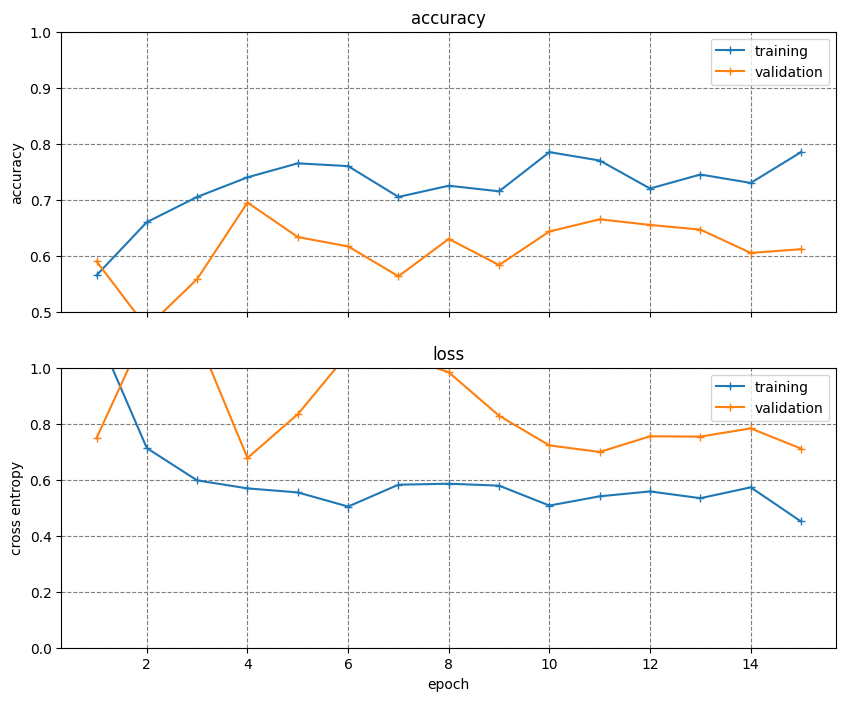

In [12]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_plot = range(1, len(val_loss) + 1)

ax[0].plot(x_plot, acc, '+-', label='training')
ax[0].plot(x_plot, val_acc, '+-', label='validation')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_ylim(0.5, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')

ax[1].plot(x_plot, loss, '+-', label='training')
ax[1].plot(x_plot, val_loss, '+-', label='validation')
ax[1].legend()
ax[1].set_ylabel('cross entropy')
ax[1].set_ylim(0, 1)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')

plt.show()

150/150 [==============================] - 40s 268ms/step


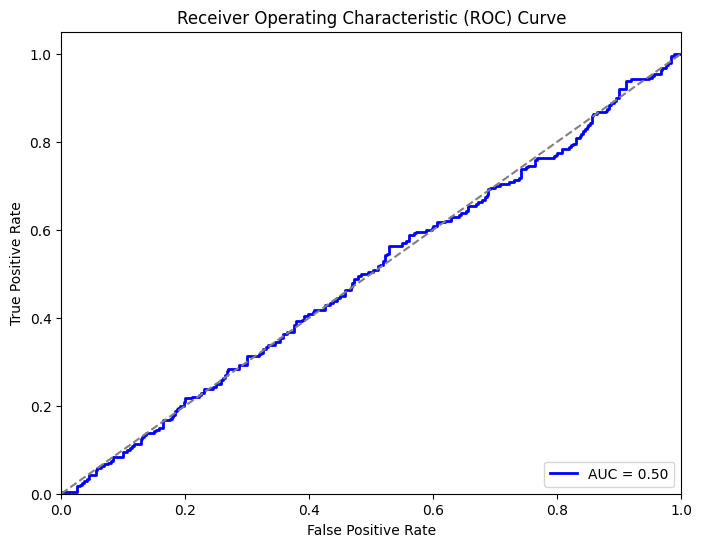

In [14]:


y_pred_prob = model.predict(validation_generator)

fpr, tpr, thresholds = roc_curve(validation_generator.labels, y_pred_prob)

roc_auc = roc_auc_score(validation_generator.labels, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
